In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from tqdm import tqdm

In [42]:
torch.manual_seed(42)
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 40
batch_size = 128
lr = 2e-4  # learning rate

In [43]:
class Generator(nn.Module):
    def __init__(self, data_shape=(1, 28, 28), noise_shape=(128, 64)):
        super().__init__()

        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        
        self.data_shape = data_shape
        self.data_dim = np.prod(data_shape)

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(noise_shape[0], 512, kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, noise):
        noise = noise.view(-1, *self.noise_shape)
        return self.generator(noise).view(-1, *self.data_shape)


class Discriminator(nn.Module):
    def __init__(self, data_shape = (1, 28, 28)):
        super().__init__()

        self.data_shape = data_shape
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=1, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, *self.data_shape)
        return self.discriminator(x).view(-1, 1)


In [44]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [45]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [46]:
data_shape = (1, 28, 28)
noise_shape = (128, 1, 1)

# models
gen = Generator(data_shape=data_shape, noise_shape=noise_shape).to(device)
disc = Discriminator(data_shape=data_shape).to(device)

gen.apply(weights_init)
disc.apply(weights_init)

# two optimizers!
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr)  # typically good to use same learning rate for gen and disc

# loss function
loss_fn = nn.BCELoss()

In [47]:
def generate_from_noise(noise, savepath):
    noise = noise[:16]
    x_hat = gen(noise)
    generated_images = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

    plt.figure()

    for i, img in enumerate(generated_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(img, cmap='binary')
        plt.axis('off')
        plt.savefig(savepath, dpi=100)

    plt.close()

In [48]:
losses_gen = []
losses_disc = []

fixed_noise = torch.randn(16, *noise_shape) # used to keep track of the generation over different iterations
fixed_noise = fixed_noise.to(device)

for epoch in range(epochs):
    for i, (x, _) in enumerate(tqdm(train_loader)):

        # Train discriminator
        opt_disc.zero_grad()

        x = x.to(device)
        z = torch.randn(x.shape[0], *noise_shape)  # better use x.shape[0] instad of batch size
        z = z.to(device)
        x_hat = gen(z)

        target_real = torch.ones((x.shape[0], 1)).to(device)  # we want the disc to predict 1 for real samples
        target_fake = torch.zeros((x.shape[0], 1)).to(device)
        pred_real = disc(x)
        pred_fake = disc(x_hat)
        loss_real = loss_fn(pred_real, target_real)
        loss_fake = loss_fn(pred_fake, target_fake)
        loss_disc = (loss_real + loss_fake) / 2
        loss_disc.backward()
        opt_disc.step()

        # Train generator
        z = torch.randn(x.shape[0], *noise_shape)
        z = z.to(device)
        x_hat = gen(z)
        
        target_real = torch.ones((x.shape[0], 1)).to(device)
        pred_fake = disc(x_hat)
        loss_gen = loss_fn(pred_fake, target_real)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        losses_disc.append(loss_disc.item())
        losses_gen.append(loss_gen.item())

        # GANs train more slowly than other models, better train every 100 iters instead than every epoch
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}")
            generate_from_noise(fixed_noise, savepath=f'generations/dcgan_{epoch+1:03d}_{i+1:03d}.png')

  9%|▉         | 43/469 [01:35<15:50,  2.23s/it]


KeyboardInterrupt: 

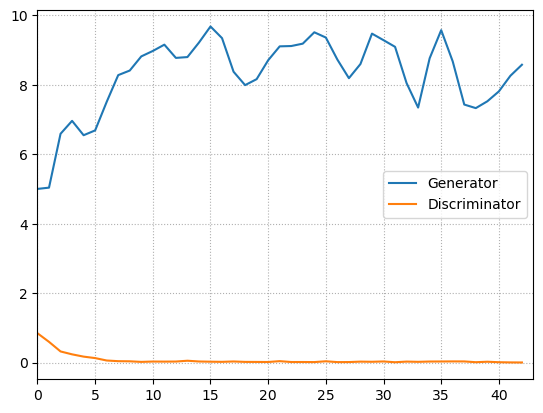

In [49]:
plt.figure()
plt.plot(losses_gen, label='Generator')
plt.plot(losses_disc, label='Discriminator')
plt.xlim([0, len(losses_gen)])
plt.grid(linestyle=':')
plt.legend()
plt.show()

In [ ]:
# torch.save(gen.state_dict(), f'saved_models/gen_dcgan.pt')
# torch.save(disc.state_dict(), f'saved_models/disc_dcgan.pt')